In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

In [2]:
MAIN_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(MAIN_DIR, 'data')
MODEL_DIR = os.path.join(MAIN_DIR, 'models')

In [3]:
data = pd.read_csv(os.path.join(DATA_DIR,'merged_data.csv'))
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Source
0,2013-12-15,0.000559,0.000904,0.000290,0.000298,0.0,1.960300e+06,Dogecoin
1,2013-12-16,0.000299,0.000866,0.000150,0.000205,0.0,1.509085e+06,Dogecoin
2,2013-12-17,0.000207,0.000289,0.000116,0.000269,0.0,2.169688e+06,Dogecoin
3,2013-12-18,0.000267,0.000362,0.000205,0.000362,0.0,3.188943e+06,Dogecoin
4,2013-12-19,0.000395,0.001520,0.000328,0.001162,0.0,1.115034e+07,Dogecoin


In [4]:
def process(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Timestamp'] = df['Date'].apply(lambda x: x.timestamp())
    df['high_low_diff'] = df['High'] - df['Low']
    df['open_close_diff'] = df['Close'] - df['Open']
    df.dropna(inplace=True);
    df.drop(['Date'], axis=1, inplace=True)
    df.sort_values('Timestamp', inplace=True)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    scaler = StandardScaler()
    X = scaler.fit_transform(df.values)
    return X

In [5]:
test = data.copy().drop(['Source'], axis=1)
test = process(test)

In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data['Timestamp'] = data['Date'].apply(lambda x: x.timestamp())
data['price_change'] = data.groupby('Source')['Close'].pct_change()
data['high_low_diff'] = data['High'] - data['Low']
data['open_close_diff'] = data['Close'] - data['Open']
data.dropna(inplace=True);
data['target'] = data['price_change'].apply(lambda x: 1 if x > 0 else 0)
data.drop(['Date', 'price_change'], axis=1, inplace=True)
data.sort_values('Timestamp', inplace=True)
data.head()

,Open,High,Low,Close,Volume,Market Cap,Source,Timestamp,high_low_diff,open_close_diff,target
1,0.000299,0.000866,0.000150,0.000205,0.0,1.509085e+06,Dogecoin,1.387152e+09,0.000716,-0.000095,0
2,0.000207,0.000289,0.000116,0.000269,0.0,2.169688e+06,Dogecoin,1.387238e+09,0.000173,0.000062,1
3,0.000267,0.000362,0.000205,0.000362,0.0,3.188943e+06,Dogecoin,1.387325e+09,0.000157,0.000094,1
4,0.000395,0.001520,0.000328,0.001162,0.0,1.115034e+07,Dogecoin,1.387411e+09,0.001191,0.000767,1
5,0.001143,0.001143,0.000662,0.000704,0.0,7.284337e+06,Dogecoin,1.387498e+09,0.000481,-0.000439,0


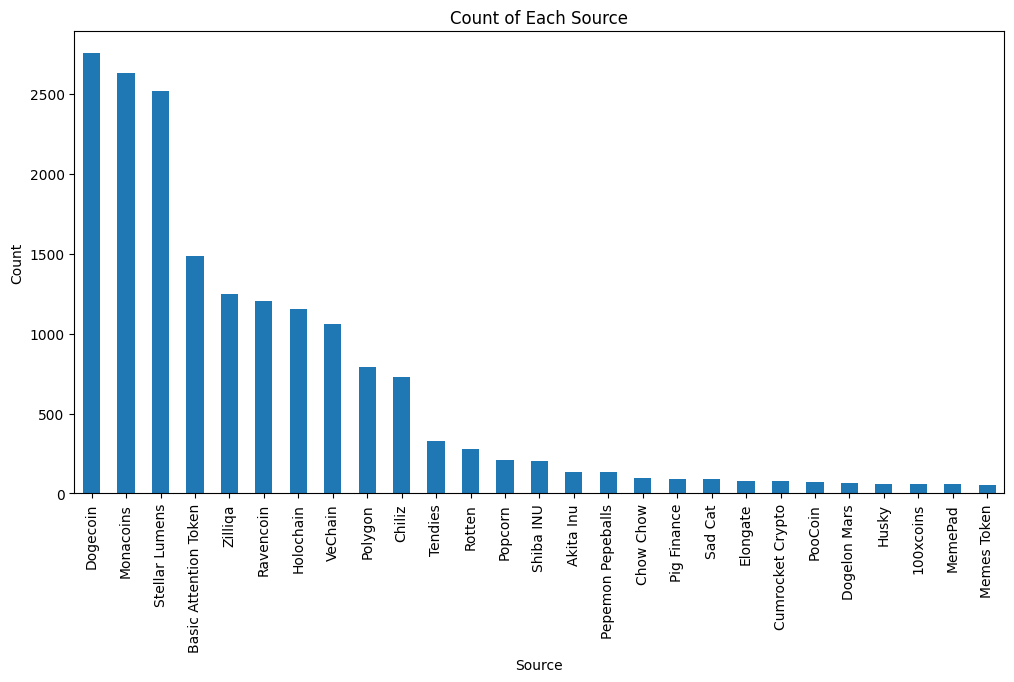

In [7]:
source_counts = data['Source'].value_counts()
source_counts.plot(kind='bar', figsize=(12, 6), title='Count of Each Source')
plt.xlabel('Source')
plt.ylabel('Count')
plt.show()

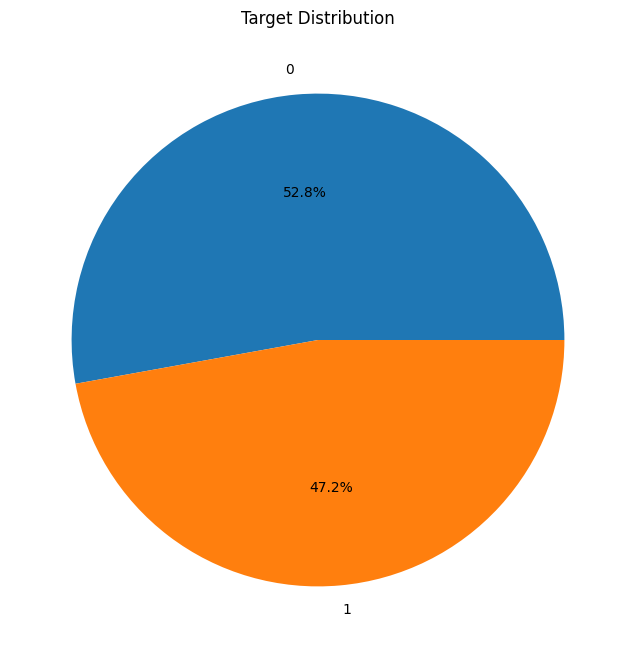

In [8]:
target_counts = data['target'].value_counts()
target_counts.plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Target Distribution')
plt.ylabel('')
plt.show()

In [9]:
model = load_model(os.path.join(MODEL_DIR, 'model.keras'))

c:\ProgramData\miniconda3\envs\ML\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
predictions = (model.predict(test) > 0.5).astype('int32')
predictions

558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

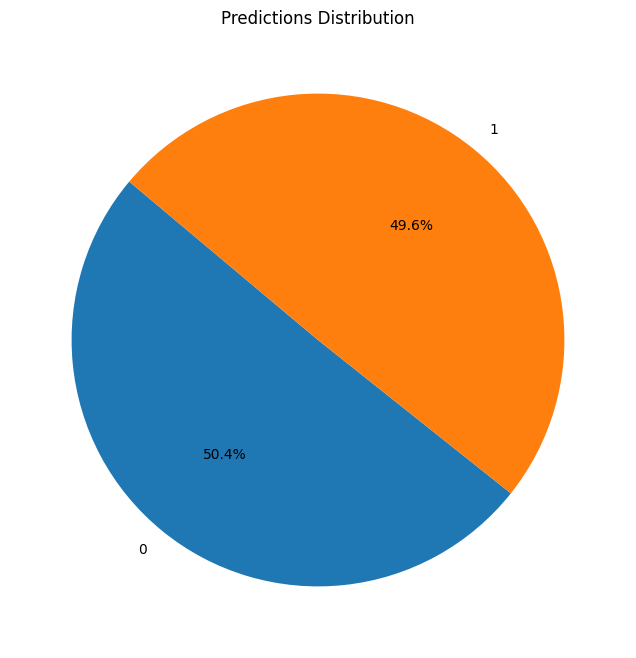

In [11]:
unique, counts = np.unique(predictions, return_counts=True)
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=140)
plt.title('Predictions Distribution')
plt.show()

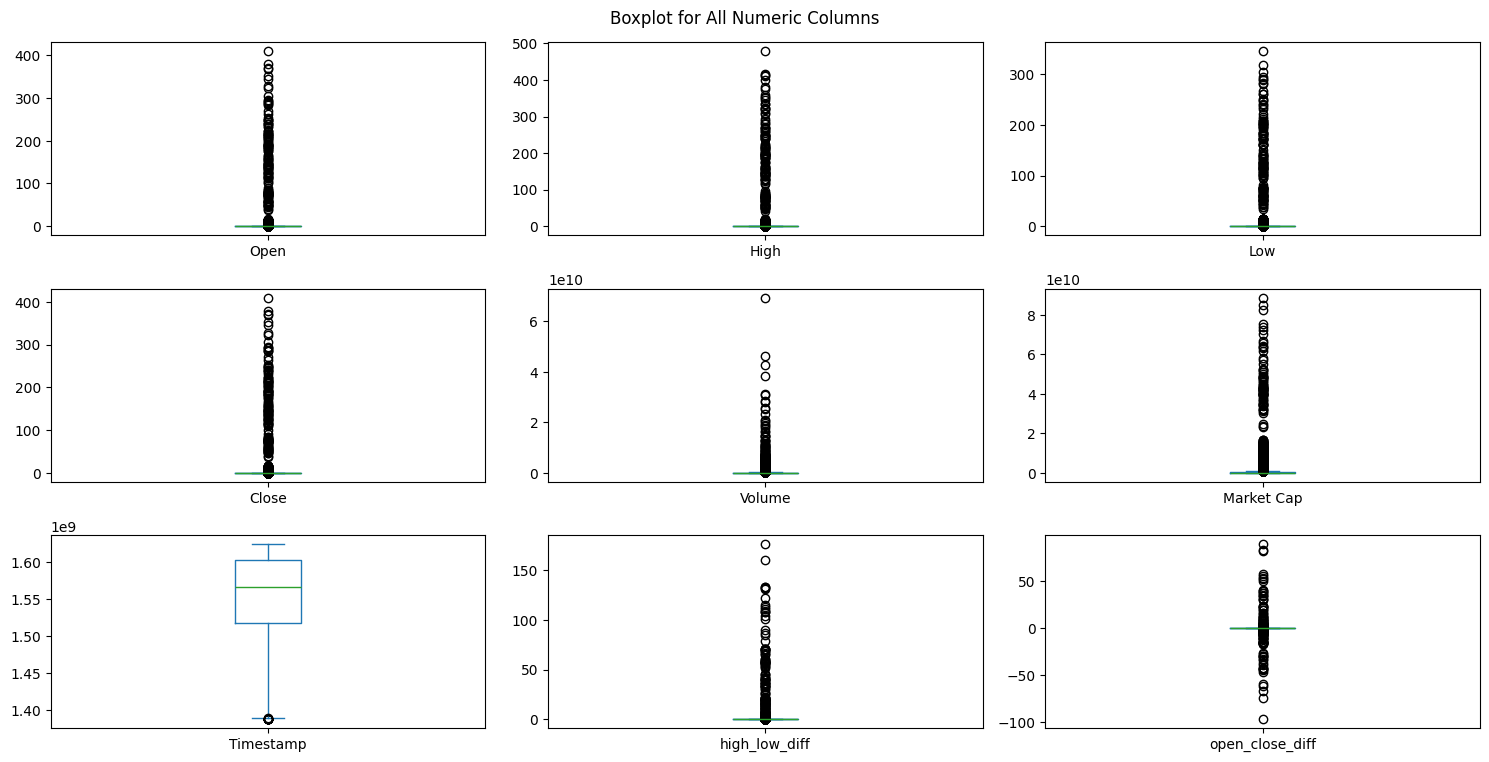

In [17]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.drop(['target'])
data[numeric_cols].plot(kind='box', subplots=True, layout=(4, 3), figsize=(15, 10), title='Boxplot for All Numeric Columns')
plt.tight_layout()
plt.show()